In [ ]:
# Import libraries here
import sqlite3
!pip install category_encoders
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

# Prepare Data

## Connect

Extract data from sql

In [12]:

# # %load_ext sql
# # %sql sqlite:////home/jovyan/nepal.
# %%sql
# SELECT distinct(district_id)
# FROM id_map
# %%sql
# SELECT count(*)
# FROM id_map
# WHERE district_id = 3
# %%sql
# SELECT  distinct(i.building_id) AS b_id ,s.* , d.damage_grade
# FROM  id_map AS i
# JOIN building_structure AS s ON i.building_id = s.building_id
# JOIN building_damage AS d ON i.building_id = d.building_id
# WHERE i.district_id = 3
# # LIMIT 5
# conn = sqlite3.connect(path)
#     query = """
#         SELECT distinct(i.building_id) AS b_id,
#            s.*,
#            d.damage_grade
#         FROM id_map AS i
#         JOIN building_structure AS s ON i.building_id = s.building_id
#         JOIN building_damage AS d ON i.building_id = d.building_id
#         WHERE district_id = 3
#     """
#     df = pd.read_sql(query,conn,index_col ='b_id')

## Import

a `wrangle` function that will use the query we created in the previous cell to create a DataFrame. In addition this function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`.
2. Drop any columns that could cause issues with leakage or multicollinearity in the model.

In [13]:
def wrangle(db_path):
    # Connect to database

    # Read query results into DataFrame
    df = pd.read_csv(db_path, index_col="building_id")

    # Identify leaky columns and drop it
    drop_col = [col for col in df.columns if "post_eq" in col]


    # Crate binary target
    df["damage_grade"] = df["damage_grade"].fillna('Grade 5')
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    drop_col.append("damage_grade")

    # Drop multicollinearity columns
    drop_col.append("count_floors_pre_eq")


    df.drop(columns=drop_col, inplace=True)

    return df

In [14]:
df = wrangle("/content/eq2015.csv")
df.head()

,district_id,vdcmun_id,ward_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,technical_solution_proposed,superstructure,severe_damage
building_id,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,9,288,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Major repair,has_superstructure_mud_mortar_stone,0
120101000021,12,1207,120703,15,364,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Reconstruction,has_superstructure_mud_mortar_stone,1
120101000031,12,1207,120703,20,384,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Minor repair,has_superstructure_mud_mortar_stone,0
120101000041,12,1207,120703,20,312,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Minor repair,has_superstructure_mud_mortar_stone,0
120101000051,12,1207,120703,30,308,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Minor repair,has_superstructure_mud_mortar_stone,0


## Explore

Are the classes in this dataset balanced?

Text(0.5, 1.0, 'Kavrepalanchok, Class Balance')

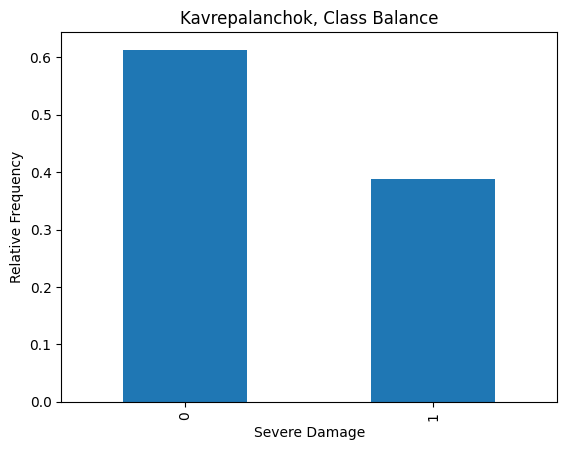

In [15]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(kind="bar")
plt.xlabel("Severe Damage")
plt.ylabel("Relative Frequency")
plt.title("Kavrepalanchok, Class Balance")


Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake?

Text(0.5, 1.0, 'Kavrepalanchok, Plinth Area vs Building Damage')

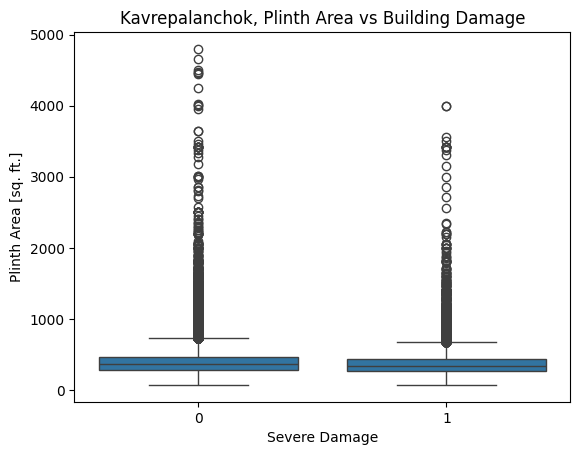

In [16]:
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df)
plt.xlabel("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage")



Are buildings with certain roof types more likely to suffer severe damage?

In [17]:
roof_pivot = df.pivot_table("severe_damage",index="roof_type")
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.367855
Bamboo/Timber-Light roof,0.415333
RCC/RB/RBC,0.032780


## Split

Creating the feature matrix `X` and target vector `y`. the target is `"severe_damage"`.

In [18]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (129239, 15)
y shape: (129239,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (82712, 15)
y_train shape: (82712,)
X_val shape: (20679, 15)
y_val shape: (20679,)


# Build Model

## Baseline

Calculating the baseline accuracy score for the model.

In [20]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.61


## Iterate

Creating a model `model_lr` that uses logistic regression to predict building damage.

In [21]:
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True), LogisticRegression(max_iter=1000))
model_lr.fit(X_train,y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'technical_solution_proposed',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [22]:
lr_train_acc = model_lr.score(X_train,y_train)
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.9308322855208434
Logistic Regression, Validation Accuracy Score: 0.9286715992069249


Perhaps a decision tree model will perform better than logistic regression.

In [23]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(max_depth=d, random_state=42))
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    validation_acc.append(model_dt.score(X_val, y_val))

Using the values in `training_acc` and `validation_acc`, ploting the validation curve for `model_dt`.

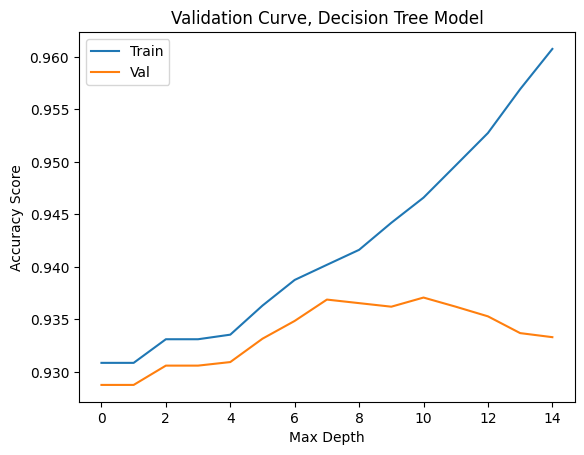

In [24]:
plt.plot(training_acc, label="Train")
plt.plot(validation_acc, label="Val")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model")
plt.legend()



In [25]:
validation_acc.index(max(validation_acc))

10

In [26]:
final_model_dt = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(max_depth=10, random_state=42))
final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'technical_solution_proposed',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64}...
has_superstructure_adobe_mud               4
has_superstructure_cement_mortar_stone     5
has_superstructure_rc_non_engineered       6
has_superstructure_bamboo                  7
has_superstructure_other                   8
has_superstructure_stone_flag              9
has_superstructure_mud_mortar_brick       10
has_superstructure_rc_engineered          11
has_superstr                              12
NaN                                       -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

## Evaluate

How does your model perform on the test set?

In [27]:
acc_train = accuracy_score(y_train, final_model_dt.predict(X_train))
acc_test = accuracy_score(y_test, final_model_dt.predict(X_test))

print("LR Training Accuracy:", acc_train)
print("LR Validation Accuracy:", acc_test)

LR Training Accuracy: 0.9442039849115001
LR Validation Accuracy: 0.9369003404518725


# Communicate Results

What are the most important features for `final_model_dt`?

In [28]:
feat_imp = pd.Series(final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_).sort_values()
feat_imp.head()

,0
11,0.000230
12,0.000255
14,0.000621
0,0.000644
8,0.000916


Creating a horizontal bar chart of `feat_imp`.

Text(0.5, 1.0, 'Kavrepalanchok Decision Tree, Feature Importance')

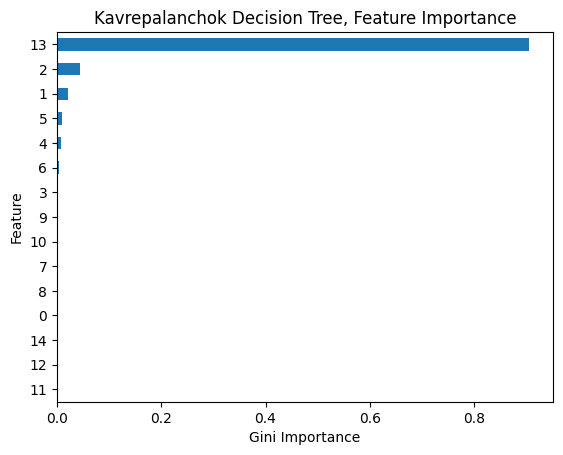

In [29]:
# Create horizontal bar chart of feature importances
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Kavrepalanchok Decision Tree, Feature Importance")

